# Nadir Altimeter in Low Resolution Mode Tutorial

more info, see Larue et al 2021, https://doi.org/10.1016/j.rse.2021.112534
 
**Goal**:
- Simulate altimeter waveform
- Output where contributions are coming from (surface vs interfaces vs volume)
- Include interface roughness

**Learning**:

This tutorial will help you use the following modules
- nadir_lrm_altimetry solver
- interface.geometrical_optics_backscatter module
- altimeter_list sensors

First, we import the necessary modules

In [49]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

from smrt import make_snowpack, make_ice_column, make_model, make_interface, PSU
from smrt.inputs import altimeter_list

from smrt.permittivity.saline_snow import saline_snow_permittivity_scharien_with_stogryn95 as ssp


### Let's create a two layer snowpack on top of a sea ice layer

We'll allow the snow to be saline and use the Scharien permittivity formulation imported as ssp above. This is because the SMRT default permittivity for snow (wetice_permittivity_bohren83) doesn't depend on salinity.

Salinity can also specified using PSU unit (4 * PSU). Dont forget to import PSU unit from globalconstant. (see above)

As we have not yet specified the interfaces, all interfaces are assumed to be flat.


In [50]:
# specified ice permittivity model of snow with ssp
snow = make_snowpack(thickness=[0.1, 0.2], microstructure_model='exponential',
                     ice_permittivity_model=ssp,density=[300, 350], 
                     corr_length=0.5e-4, temperature=260, salinity=[0.001, 0.006] )

#specfied ice type (firstyear or multiyear)
ice = make_ice_column(ice_type='firstyear',
                    thickness=[2], temperature=260, 
                    microstructure_model='independent_sphere',
                    radius=1e-3,
                    brine_inclusion_shape='spheres',
                    density=910,
                    salinity=32*PSU,
                    add_water_substrate=True)

medium = snow + ice

### Specify sensor

There are a number of altimeter sensors in altimeter_list. We'll use CryoSat-2 in SIN mode.

In [51]:
sensor = altimeter_list.cryosat2_sin()

### Configure SMRT model

Use the Improved Born Approximation electromagnetic model and the LRM altimeter solver

In [52]:
altimodel = make_model("iba", "nadir_lrm_altimetry")

### Run SMRT

and plot altimeter waveform

In [53]:
result = altimodel.run(sensor, medium)

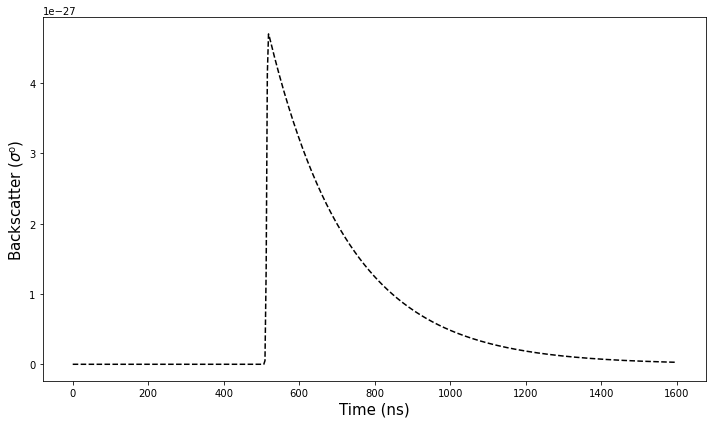

In [54]:
plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

#time is in nano seconds, 1 bins = 3.125 ns for Cryosat. Check other sensor specs in altimeter_list
ax.plot(result.t_gate*1e9, result.sigma(), 'k--')

ax.set_xlabel('Time (ns)', size = 15)
ax.set_ylabel('Backscatter ($\sigma⁰$)', size = 15)
plt.tight_layout()

The initial sharp rise is called the leading edge, and is often used as the basis for retracker algorithms to calculate the ice freeboard. The descending curve is the trailing edge.

Let's see where the radar echo is coming from. For this, we'll need to specify a radiative transfer option when configuring SMRT to keep track of the contributions.

In [55]:
altimodel_with_returns = make_model("iba", "nadir_lrm_altimetry", rtsolver_options=dict(return_contributions=True))

#### Re-run the model and replot the graph showing individual contributions

In [56]:
result_with_returns = altimodel_with_returns.run(sensor, medium)

In [57]:
#show results in xarray format for more details. See the "contribution" dimension.
result_with_returns.sigma()

<xarray.DataArray (contribution: 4, t_gate: 512)>
array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [7.88893766e-44, 1.69048664e-43, 5.63495547e-44, ...,
        2.96239577e-29, 2.91893573e-29, 2.87611326e-29],
       [7.88893766e-44, 1.69048664e-43, 5.63495547e-44, ...,
        2.96239577e-29, 2.91893573e-29, 2.87611326e-29]])
Coordinates:
    theta_inc     int64 0
  * contribution  (contribution) <U10 'surface' 'interfaces' 'volume' 'total'
  * t_gate        (t_gate) float64 0.0 3.125e-09 ... 1.594e-06 1.597e-06

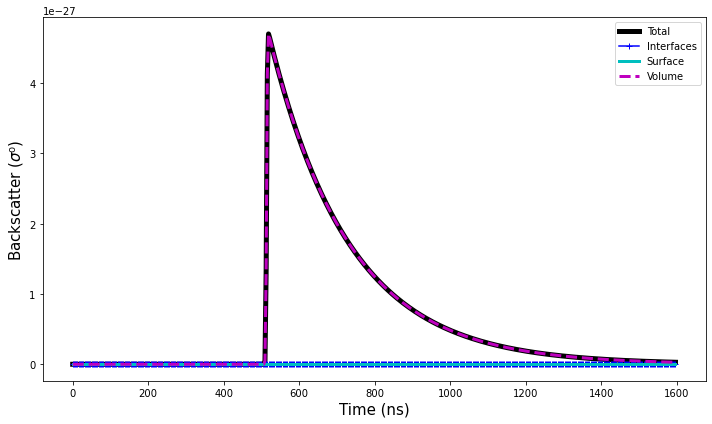

In [58]:
plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(result_with_returns.t_gate*1e9, result_with_returns.sigma(contribution='total'), 'k-', linewidth=5, label='Total')
ax.plot(result_with_returns.t_gate*1e9, result_with_returns.sigma(contribution='interfaces'), 'b+-', label='Interfaces')
ax.plot(result_with_returns.t_gate*1e9, result_with_returns.sigma(contribution='surface'), 'c-', linewidth=3, label='Surface')
ax.plot(result_with_returns.t_gate*1e9, result_with_returns.sigma(contribution='volume'), 'm--', linewidth=3, label='Volume')

ax.legend()
ax.set_xlabel('Time (ns)', size = 15)
ax.set_ylabel('Backscatter ($\sigma⁰$)', size = 15)
plt.tight_layout()

Here, all interfaces are smooth and the signal is coming from volume scattering in the snow. Surfaces are rarely smooth though....

Image below is from the AKROSS field campaign, showing roughness in both the surface and the underlying sea ice.


In [59]:
# import image module
from IPython.display import Image
  
# get the image
Image(url="IMG_1682.JPG", width=500, height=300)

### Add in a rough interface at the snow surface

For now, this will be the Geometrical Optics model

In [60]:
rough_interface = make_interface("geometrical_optics_backscatter", mean_square_slope=0.03)

#surface parameter can be use in make_snowpack to define the surface interface
rough_snow = make_snowpack(thickness=[0.1, 0.2], microstructure_model='exponential',
                     ice_permittivity_model=ssp,density=[300, 350], 
                     corr_length=0.5e-4, temperature=260, salinity=[0.01, 0.06],
                     surface=rough_interface)

rough_surface_medium = rough_snow + ice

Run the model and see what this does to the return contribution

In [61]:
rough_surf_result_with_returns = altimodel_with_returns.run(sensor, rough_surface_medium)
#warning when using geo optic... because of incident angle = 0 for altimeter, Ignore warning...

/home/picardgh/MW/Microsnow/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in true_divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))


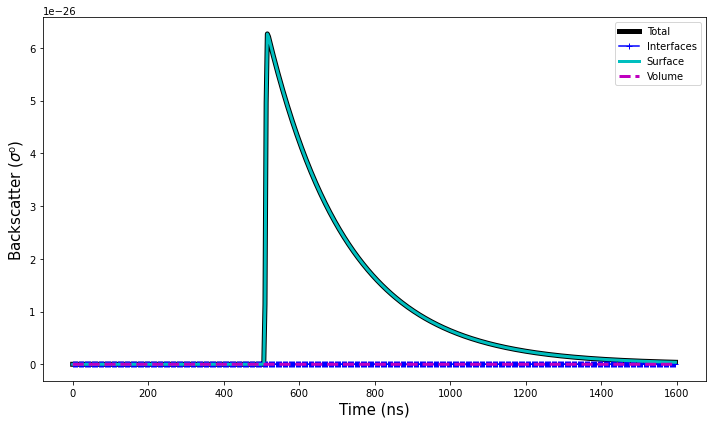

In [62]:
plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(rough_surf_result_with_returns.t_gate*1e9, rough_surf_result_with_returns.sigma(contribution='total'), 'k-', linewidth=5, label='Total')
ax.plot(rough_surf_result_with_returns.t_gate*1e9, rough_surf_result_with_returns.sigma(contribution='interfaces'), 'b+-', label='Interfaces')
ax.plot(rough_surf_result_with_returns.t_gate*1e9, rough_surf_result_with_returns.sigma(contribution='surface'), 'c-', linewidth=3, label='Surface')
ax.plot(rough_surf_result_with_returns.t_gate*1e9, rough_surf_result_with_returns.sigma(contribution='volume'), 'm--', linewidth=3, label='Volume')

ax.legend()
ax.set_xlabel('Time (ns)', size = 15)
ax.set_ylabel('Backscatter ($\sigma⁰$)', size = 15)
plt.tight_layout()

The return is now dominated by the surface. The return from volume scattering is still of a similar order of magnitude as the previous smooth surface simulation - you can see this by printing out the largest amplitude of returns from the surface, there's just much more from the rough surface.

In [63]:
# Print out and compare results
max(result_with_returns.sigma(contribution='volume')).values, max(rough_surf_result_with_returns.sigma(contribution='volume')).values

(array(4.70149917e-27), array(1.42212098e-29))

If you want to check how the medium is parameterised you can just print it out and look at the properties!

In [64]:
rough_surface_medium

Snowpack:       layer                                                                 \
  thickness microstructure_model density temperature liquid_water salinity   
0       0.1          Exponential   300.0       260.0          0.0    0.010   
1       0.2          Exponential   350.0       260.0          0.0    0.060   
2       2.0    IndependentSphere   910.0       260.0          NaN    0.032   
s       NaN                  NaN     NaN         NaN          NaN      NaN   

             microstructure                                        interface  \
    ice_type    frac_volume corr_length radius                          name   
0       None       0.327261     0.00005    NaN  GeometricalOpticsBackscatter   
1       None       0.381804     0.00005    NaN                          Flat   
2  firstyear       0.149222         NaN  0.001                          Flat   
s        NaN            NaN         NaN    NaN                           NaN   

                                      substrate  
  mean_square_slope shadow_correction      name  
0              0.03              True       NaN  
1               NaN              None       NaN  
2               NaN              None       NaN  
s               NaN               NaN      Flat

### Make internal rough surface

You can just copy the snowpack and substitute one of the interfaces for a rough one. We'll use the rough interface that we have already made and put it at the bottom of the medium. Interfaces, as with layers, are numbered from 0 at the top (-1 just references the last one). Interface index refer to the top interface of the layer index

In [65]:
interface_snow = deepcopy(snow)
#adding snow and ice together
rough_base_medium = interface_snow + ice
#set rough sea ice interface
#by having snow and ice together the last interface becomes the sea ice surface.
rough_base_medium.interfaces[-1] = rough_interface

In [66]:
rough_base_result_with_returns = altimodel_with_returns.run(sensor, rough_base_medium)

/home/picardgh/MW/Microsnow/smrt/smrt/interface/geometrical_optics_backscatter.py:72: RuntimeWarning: divide by zero encountered in true_divide
  gamma *= 1 / (1 + shadow_function(self.mean_square_slope, 1 / np.sqrt(tantheta_i2)))


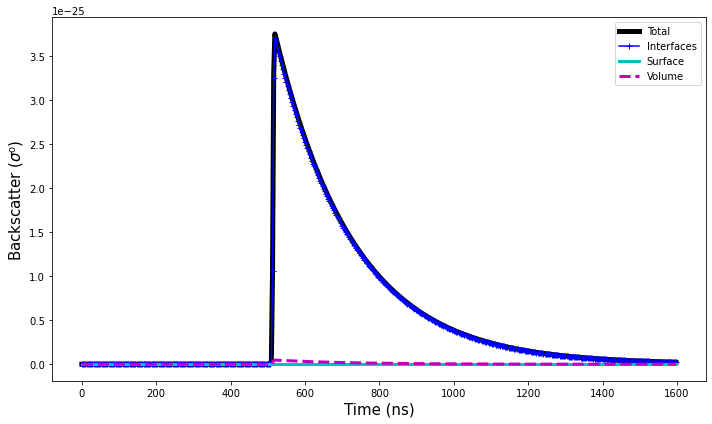

In [67]:
plt.close()
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))

ax.plot(rough_base_result_with_returns.t_gate*1e9, rough_base_result_with_returns.sigma(contribution='total'), 'k-', linewidth=5, label='Total')
ax.plot(rough_base_result_with_returns.t_gate*1e9, rough_base_result_with_returns.sigma(contribution='interfaces'), 'b+-', label='Interfaces')
ax.plot(rough_base_result_with_returns.t_gate*1e9, rough_base_result_with_returns.sigma(contribution='surface'), 'c-', linewidth=3, label='Surface')
ax.plot(rough_base_result_with_returns.t_gate*1e9, rough_base_result_with_returns.sigma(contribution='volume'), 'm--', linewidth=3, label='Volume')

ax.legend()
ax.set_xlabel('Time (ns)', size = 15)
ax.set_ylabel('Backscatter ($\sigma⁰$)', size = 15)
plt.tight_layout()

Now the altimeter waveform is dominated by scattering from the interfaces i.e. the snow-sea ice interface.


### Further investigations

1. Increase the number of layers in the snowpack and see what happens when you put a rough interface between snow layers

2. Try re-running the simulations with an airborne sensor e.g. importing the asiras_lam from altimeter_list. How does the waveform change?

3. Look at the IEM roughness model - where might you use IEM instead of the Geometrical Optics model (tip: frequency)

4. How does the waveform change with snow salinity?

